In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier
import scikitplot as skplt
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, f1_score,auc,roc_curve,roc_auc_score, precision_recall_curve
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterSampler, ParameterGrid
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.svm import SVC
import pickle
from scipy import stats
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from tqdm import tqdm
import datetime
import time
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, StratifiedKFold, KFold
from sklearn.decomposition import PCA

# Data Processing

In [2]:
# loading data and initial inspection to make sure data is correct
train_data = pd.read_csv("train.csv",encoding="utf_8_sig")
print(train_data.shape)
print(list(train_data), len(list(train_data)))
train_data.head()

(9681, 25)
['id', 'neighbourhood', 'room_type', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'host_since', 'host_is_superhost', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'cleaning_fee', 'guests_included', 'extra_people', 'maximum_nights', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification', 'price'] 25


,id,neighbourhood,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,host_since,...,cleaning_fee,guests_included,extra_people,maximum_nights,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,price
0,727,Palermo,Entire home/apt,1,170,5/12/20,2.48,4,346,8/1/13,...,2092,1,0,365,t,f,strict_14_with_grace_period,f,f,2
1,6274,Colegiales,Private room,1,11,7/1/19,0.57,1,0,2/14/14,...,558,1,0,15,f,f,moderate,f,f,1
2,6025,Recoleta,Entire home/apt,3,2,11/23/19,0.08,19,360,10/19/17,...,1052,3,351,90,t,f,moderate,f,f,3
3,8931,Recoleta,Entire home/apt,2,1,11/1/19,0.13,1,267,2/1/19,...,0,4,0,1125,t,f,flexible,f,f,2
4,7524,San Nicolás,Entire home/apt,2,31,12/26/19,1.54,5,365,1/24/15,...,2092,1,0,365,t,f,moderate,f,f,3


In [3]:
# initialize one hot encoder from sklearn
neigh_encoder = LabelBinarizer()
room_encoder = LabelBinarizer()
bed_encoder = LabelBinarizer()
cancel_encoder = LabelBinarizer()
neigh_encoder.fit(train_data['neighbourhood'])
room_encoder.fit(train_data['room_type'])
bed_encoder.fit(train_data['bed_type'])
cancel_encoder.fit(train_data['cancellation_policy'])

def data_processing_onehotencode(data):
    # converting date features to the number of days from today (11/03/2020)
    current_date = ["11/03/20"]*len(data["number_of_reviews"])
    data["today_date"] = current_date
    data["last_review"] = (pd.to_datetime(data['today_date']) - pd.to_datetime(data['last_review']))
    data["host_since"] = (pd.to_datetime(data['today_date']) - pd.to_datetime(data['host_since']))
    data['last_review'] = data["last_review"].astype('timedelta64[D]').astype(float)
    data['host_since'] = data["host_since"].astype('timedelta64[D]').astype(float)
    data = data.drop(["today_date"],axis=1)
    
    # encode the neighbourhood feature with one hot encoding
    neigh_onehot = neigh_encoder.transform(data['neighbourhood'])
    neigh_onehot_df = pd.DataFrame(neigh_onehot)
    data.drop('neighbourhood', axis=1, inplace=True)
    data = pd.concat([neigh_onehot_df, data], axis=1)
    
    # encode the room_type feature with one hot encoding
    room_onehot = room_encoder.transform(data['room_type'])
    room_onehot_df = pd.DataFrame(room_onehot)
    data.drop('room_type', axis=1, inplace=True)
    data = pd.concat([room_onehot_df, data], axis=1)
    
    # encode the bed_type feature with one hot encoding
    bed_onehot = bed_encoder.transform(data['bed_type'])
    bed_onehot_df = pd.DataFrame(bed_onehot)
    data.drop('bed_type', axis=1, inplace=True)
    data = pd.concat([bed_onehot_df, data], axis=1)
    
    # encode the cancellation_policy feature with one hot encoding
    cancel_onehot = cancel_encoder.transform(data['cancellation_policy'])
    cancel_onehot_df = pd.DataFrame(cancel_onehot)
    data.drop('cancellation_policy', axis=1, inplace=True)
    data = pd.concat([cancel_onehot_df, data], axis=1)
    
    # encode the boolean features by mapping t to 2 and f to 1
    data['host_is_superhost'] = data.host_is_superhost.map(dict(t=2, f=1))
    data['instant_bookable'] = data.instant_bookable.map(dict(t=2, f=1))
    data['require_guest_profile_picture'] = data.require_guest_profile_picture.map(dict(t=2, f=1))
    data['require_guest_phone_verification'] = data.require_guest_phone_verification.map(dict(t=2, f=1))
    
    # dropping features that are useless for training purposes
    data.drop('id', axis=1, inplace=True)
    data.drop("is_business_travel_ready", axis=1, inplace=True)
    
    return data

# Training

Train ACC: 0.99988  Train Auc: 1.00000  Test ACC: 0.59257  Test Auc: 0.82723 


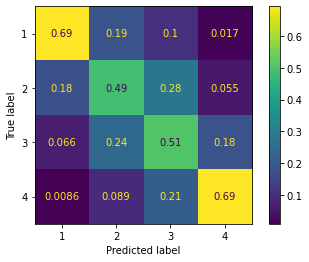

Classification Report: 
               precision    recall  f1-score   support

           1      0.725     0.693     0.709       362
           2      0.496     0.488     0.492       379
           3      0.463     0.507     0.484       365
           4      0.719     0.692     0.705       347

    accuracy                          0.593      1453
   macro avg      0.601     0.595     0.597      1453
weighted avg      0.598     0.593     0.595      1453



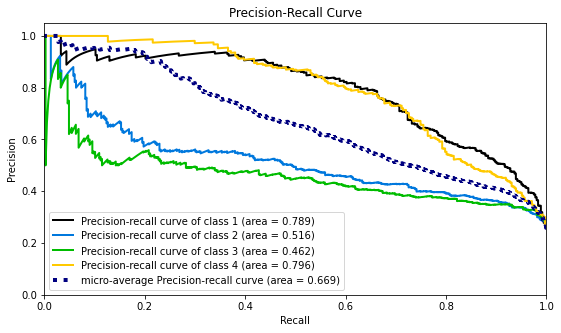

In [5]:
# load data and encode the data
train_data = pd.read_csv("train.csv",encoding="utf_8_sig")
train_data = data_processing_onehotencode(train_data)

# split data into X and y (data and label)
X = train_data.drop(columns=['price'], axis=1)
y = train_data['price']

# split training set into training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=2020)

# apply standardscaling to data
scale = StandardScaler()
scale.fit(X_train)
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)

# initialize classifier and fit the training data
xgb = XGBClassifier(
    colsample_bylevel=0.6,
    colsample_bytree=0.7,
    subsample=0.8999,
    random_state=1,
    n_jobs=-1,
    min_child_weight=0.4,
    max_depth=12,
    n_estimators=210,
    learning_rate=0.05,
    eval_metric= 'auc'
)
xgb.fit(X_train,y_train)

# make prediction for evaluation
y_train_ypred = xgb.predict(X_train)
y_train_prob = xgb.predict_proba(X_train)

y_test_ypred = xgb.predict(X_test)
y_test_prob = xgb.predict_proba(X_test)
y_probas = xgb.predict_proba(X_test)

# evaluate the model with validation set
train_acc, train_auc, test_acc, test_auc = metrics.accuracy_score(y_train, y_train_ypred), roc_auc_score(y_train, y_train_prob, multi_class='ovo'),metrics.accuracy_score(y_test, y_test_ypred), roc_auc_score(y_test, y_test_prob, multi_class='ovo')
print("Train ACC: {:<8.5f} Train Auc: {:<8.5f} Test ACC: {:<8.5f} Test Auc: {:<8.5f}".format(train_acc, train_auc, test_acc, test_auc))

# plot confusion matrix
plot_confusion_matrix(xgb, X_test, y_test, normalize='true')
plt.show() 
print('='*100)
print('Classification Report: \n', classification_report(y_test, y_test_ypred, digits=3))
print('='*100)

# plot precision recall
skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(9,5))
plt.show()

# Submission

In [6]:
def create_submission(clf, data_process_function, output='my_submission.csv'):
    # load test data
    submission_data_raw = pd.read_csv("test.csv",encoding="utf_8_sig")
    submission_data = data_process_function(submission_data_raw)
    submission_result = pd.DataFrame()
    # apply standardscaler fitted earlier
    X_submission = submission_data
    X_submission = scale.transform(X_submission)
    y_submission = clf.predict(X_submission)
    # record results with ids
    submission_result['id'] = submission_data_raw['id']
    submission_result['price'] = y_submission
    # save submission
    submission_result.to_csv(output, index=False)
    print(submission_data_raw.shape, submission_result.shape)

In [7]:
# create submission csv for kaggle
create_submission(xgb, data_processing_onehotencode, output='xgb.csv')

(4149, 25) (4149, 2)
